In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from nltk.stem import PorterStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
true_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

In [3]:
true_news

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
fake_news

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
true_df = pd.concat([true_news['title'], pd.Series(0, index=true_news.index, name='label')], axis=1)
fake_df = pd.concat([fake_news['title'], pd.Series(1, index=fake_news.index, name='label')], axis=1)

In [6]:
true_df

,title,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorities,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [7]:
fake_df

,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [8]:
news_df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=34).reset_index(drop=True)

In [9]:
ps = PorterStemmer()

def process_title(title):
    new_title = title.lower()
    new_title = re.sub(r'\$[^\s]+', 'dollar', new_title)
    new_title = re.sub(r'[^a-z0-9\s]', '', new_title)
    new_title = re.sub(r'[0-9]+', 'number', new_title)
    new_title = new_title.split(" ")
    new_title = list(map(lambda x: ps.stem(x), new_title))
    new_title = list(map(lambda x: x.strip(), new_title))
    if '' in new_title:
        new_title.remove('')
    return new_title


In [10]:
titles = news_df['title'].apply(process_title)

labels = np.array(news_df['label'])

In [11]:
# Get size of vocabulary
vocabulary = set()

for title in titles:
    for word in title:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for title in titles:
    if len(title) > max_seq_length:
        max_seq_length = len(title)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 17807
Max sequence length: 44


In [12]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(titles)

sequences = tokenizer.texts_to_sequences(titles)

word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_seq_length)

In [13]:
model_inputs

array([[   0,    0,    0, ...,    7, 1459,   13],
       [   0,    0,    0, ...,    6,   15, 1299],
       [   0,    0,    0, ...,    1, 3843,  598],
       ...,
       [   0,    0,    0, ...,  260,    9,   52],
       [   0,    0,    0, ..., 1702, 1300,    4],
       [   0,    0,    0, ...,   13, 3396,   64]])

In [14]:
model_inputs.shape

(44898, 44)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels)

In [16]:

embedding_dim = 64


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(gru)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


batch_size = 32
epochs = 3

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)
    ]
)

Epoch 1/3
842/842 [==============================] - 16s 12ms/step - loss: 0.1642 - accuracy: 0.9314 - auc: 0.9834 - val_loss: 0.0924 - val_accuracy: 0.9669 - val_auc: 0.9944 - lr: 0.0010
Epoch 2/3
842/842 [==============================] - 10s 12ms/step - loss: 0.0547 - accuracy: 0.9805 - auc: 0.9978 - val_loss: 0.1015 - val_accuracy: 0.9656 - val_auc: 0.9931 - lr: 0.0010
Epoch 3/3
842/842 [==============================] - 10s 12ms/step - loss: 0.0266 - accuracy: 0.9911 - auc: 0.9993 - val_loss: 0.1122 - val_accuracy: 0.9648 - val_auc: 0.9921 - lr: 0.0010


In [18]:
print(model.evaluate(X_test, y_test))

351/351 [==============================] - 2s 6ms/step - loss: 0.1154 - accuracy: 0.9644 - auc: 0.9915
[0.11541754007339478, 0.9643652439117432, 0.9915432929992676]


In [41]:
y_pred = model.predict(X_test)
print(y_pred)
prediction = []
for i in range(len(y_pred)):
    if y_pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)


351/351 [==============================] - 1s 4ms/step
[[9.9921227e-01]
 [9.9995399e-01]
 [5.5336845e-05]
 ...
 [8.8464259e-04]
 [9.9995840e-01]
 [1.2104036e-05]]


In [43]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test,prediction)
print(classification_report(y_test,prediction))
print("Model Accuracy : ", accuracy)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5380
           1       0.98      0.95      0.97      5845

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225

Model Accuracy :  0.9643652561247216


<AxesSubplot:>

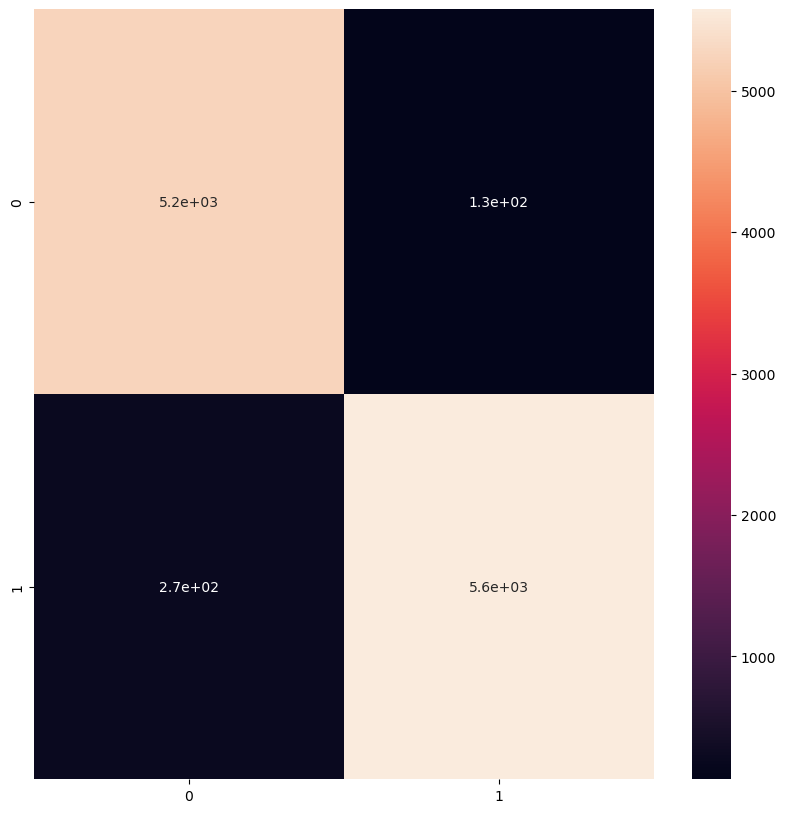

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test,prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

In [46]:
from sklearn.metrics import roc_curve
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

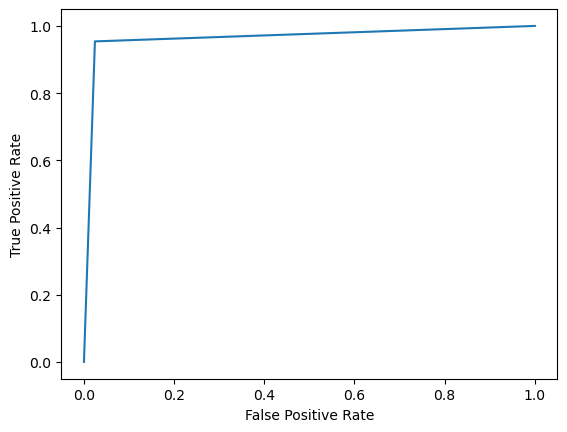

In [47]:
plot_roc_curve(y_test,prediction)